In [543]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit, vectorize, prange
import matplotlib
import matplotlib.cm as cm
import imageio
import os
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [593]:
@njit('float64[:,:,:](int64[:,:,:], bool_)', parallel=True)
def add_padding(mp, is_periodic):
    padding = np.zeros((mp.shape[0] + 2, mp.shape[1] + 2, mp.shape[2] + 2))
    padding[1:-1, 1:-1, 1:-1] = mp
    
    if is_periodic:
        padding[1:-1, 1:-1, -1] = padding[1:-1, 1:-1, 1]
        padding[1:-1, 1:-1, 0] = padding[1:-1, 1:-1, -2]

        padding[1:-1, -1, 1:-1] = padding[1:-1, 1, 1:-1]
        padding[1:-1, 0, 1:-1] = padding[1:-1, -2, 1:-1]

        padding[-1, 1:-1, 1:-1] = padding[1, 1:-1, 1:-1]
        padding[0, 1:-1, 1:-1] = padding[-2, 1:-1, 1:-1]
    
    return padding

In [410]:
@njit
def sum_matrix(matr):
    return np.sum(np.ravel(matr))

In [597]:
@njit(parallel=True)
def count_neighbours(mp):
    result = np.zeros((mp.shape[0], mp.shape[1], mp.shape[2]))
    padded = add_padding(mp, is_periodic=True)

    for i in prange(mp.shape[0]):
        for j in prange(mp.shape[1]):
            for k in prange(mp.shape[2]):
                result[i, j, k] = sum_matrix(mp[i:i + 3, j:j + 3, k:k + 3])
    
    return np.subtract(result, mp)

In [598]:
# %timeit _ = count_neighbours(game.map)

81.2 µs ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [652]:
# Conditions from: https://wpmedia.wolfram.com/uploads/sites/13/2018/02/01-3-1.pdf
@njit(parallel=True)
def step(mp):
    neighbours = count_neighbours(mp)
    new_map = (
        ((mp == 0) & (neighbours == 5)) | 
        (mp == 1) & ((neighbours >= 4) & (neighbours <= 5))
    )
    return new_map


In [654]:
# %timeit _ = step(game.map)

142 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [655]:
class Game3D:
    def __init__(self,
                map_size=3,
                positive_ratio=0.3,
                is_periodic=True):
        
        self.map_size = map_size
        self.positive_ratio = positive_ratio
        self.is_periodic = is_periodic
        
        self.generate_init_map()
    
    def generate_init_map(self):
        self.map = np.random.choice(
            2, 
            [self.map_size] * 3, 
            p=[1 - self.positive_ratio, self.positive_ratio]
        )
    
    def show_map(self, padded=False):      
        mp = self.padded if padded else self.map
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')
        ax.voxels(mp, facecolors=(0.2, 1.0, 0.2, 0.2), edgecolor='k')
#         plt.axis('off')
        plt.show()
    
    def count_neighbours(self):
        return count_neighbours(self.map)
    
    def step(self):
        self.map = step(self.map).astype(int)


In [665]:
game = Game3D(map_size=5, positive_ratio=0.7, is_periodic=True)

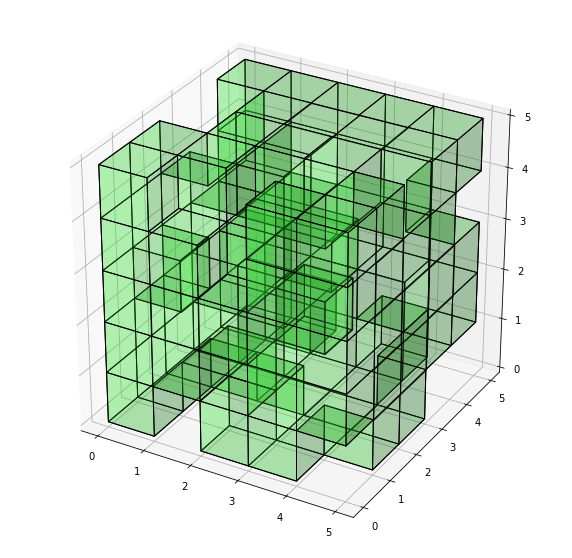

In [666]:
game.show_map()

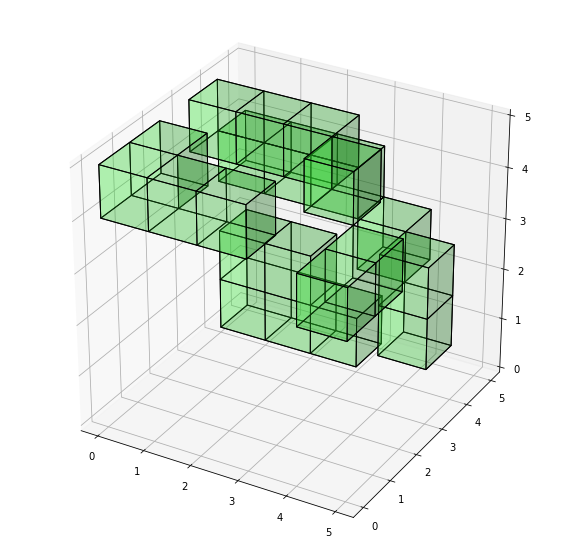

In [667]:
game.step()
game.show_map()